<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/train_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a siamese neural network to recognize whether two cat faces are the same cat.  For line-by-line details of the code, see https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/.

The training data is generated by the script `image_pair_generator.ipynb`.

The next cell is the `config.py` file.

In [1]:
# Configuration parameters

# import the necessary packages
import os

# specify the shape of the inputs for our network
IMG_SIZE = 244 # Must agree with this variable in the image_pair_generator notebook
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # 3 channels for RGB
EMBEDDING_DIMENSIONS = 48 # number of dimensions of embedding vector

# specify the batch size, number of epochs, and number of
# epochs to wait before declaring an early stop to the fitting
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 10

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the training images folder
IMAGE_FOLDER = 'cat-face-transformed'

# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [2]:
!mkdir output

The next two cells comprise the `siamese_network.py` file.

In [3]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
def build_siamese_model(inputShape=IMG_SHAPE, embeddingDim=EMBEDDING_DIMENSIONS):
  """
  Build a siamese neural network

  # Arguments
  inputShape:   shape of the input images
  embeddingDim: dimension of the embedding vector

  # Returns
  a Keras model instance
  """

	# specify the inputs for the feature extractor network
  inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  # build the model and return it
  model = Model(inputs, outputs)
  model.summary()
  return model

The next six cells comprise the `utils.py` file.

In [5]:
# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
def read_image(filename):
  return plt.imread(os.path.join('/content', IMAGE_FOLDER, filename))

In [7]:
def load_train_test_split(df):
  """
  Splits the data into training and testing sets.

  df is assumed to have the following structure:
  1. df.columns = [filename, label]
  2. Each filename of an original (not transformed) image is of the form 'imgNNN.jpg'
  3. df.label is a string which is the numeric part of the filename (as a string, not as an int)
  4. There are M transforms of each original.
  """
  # split the data into training and testing splits using 75% of
	# the data for training and the remaining 25% for testing
  labels = df['label'].unique()
  train_df = pd.DataFrame(columns=df.columns)
  test_df = pd.DataFrame(columns=df.columns)
  for i in range(len(labels)):
    label = labels[i]
    label_index = df.groupby('label').get_group(label).index.to_list()
    train_index = label_index[:int(len(label_index) * 0.75)]
    test_index = label_index[int(len(label_index) * 0.75):]
    train_df = pd.concat([train_df, df.iloc[train_index]])
    test_df = pd.concat([test_df, df.iloc[test_index]])
  return [train_df['filename'], train_df['label']], [test_df['filename'], test_df['label']]

In [8]:
def make_pairs(images, labels):
	"""
	Make a train or test set for the siamese neural network by creating
	a set of image pairs and a corresponding set of labels which are
	either positive or negative.

	# Arguments
		images: list of images
		labels: list of labels
	# Returns
		tuple of (image pairs, pos/neg labels)
	"""

	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

  # Build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	idx = [np.where(labels == i)[0] for i in np.unique(labels)]
	# Create a dataframe whose index is the set of unique labels
	# and whose columns are the index values of images which belong
	# to that label.
	idx_df = pd.DataFrame(idx, index=np.unique(labels))

  # loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images.iloc[idxA]
		label = labels.iloc[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		indexes = idx_df.loc[label].values
		idxB = np.random.choice(indexes)
		posImage = images.iloc[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
    # grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(np.unique(labels) != label)[0]
		negImage = images.iloc[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [9]:
def euclidean_distance(vectors):
  """
  Compute the euclidean distance between two feature vectors.

  # Arguments
  vectors:  list containing two feature vectors

  # Returns
  euclidean distance between the vectors
  """
	# unpack the vectors into separate lists
  (featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [10]:
def plot_training(H, plotPath):
  """
  Plot the training history for loss and accuracy


  # Arguments
  H: training history
  plotPath: path to save the plot
  """

	# construct a plot that plots and saves the training history
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  plt.plot(H.history["accuracy"], label="train_acc")
  plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig(plotPath)

The next two cells comprise the file `train_siamese_network.py`.

In [ ]:
# BE SURE to upload `cat-face-transformed.zip` before running this cell.
!unzip cat-face-transformed.zip
# Print the number of unzipped files
!ls -1 ./cat-face-transformed | wc -l

In [12]:
# BE SURE to upload file `cat-face-transformed.csv` before running this cell
df = pd.read_csv(os.path.join('/content', IMAGE_FOLDER + '.csv'))

[INFO] loading cat-face-transformed dataset...
[INFO] preparing positive and negative pairs...
[INFO] building siamese network...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 244, 244, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 122, 122, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 122, 122, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      16448     
                                                               

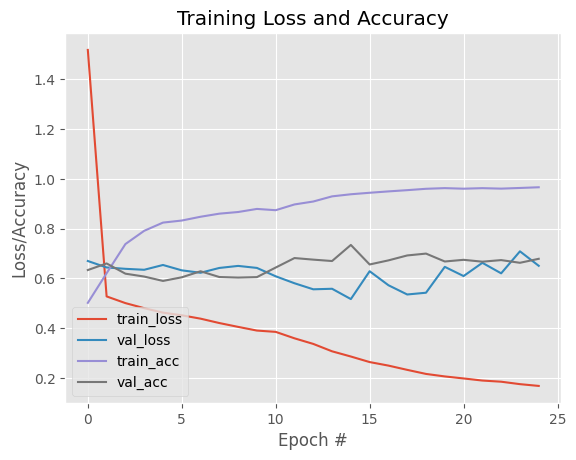

In [15]:
# load cat-face-transformed dataset, consisting of 244x244 images of cats.
# The dataset has about 100 original images of cats amd 50 transforms of
# each original.
print("[INFO] loading cat-face-transformed dataset...")
(trainX, trainY), (testX, testY) = load_train_test_split(df)

# add a channel dimension to the images
#trainX = np.expand_dims(trainX, axis=-1)
#testX = np.expand_dims(testX, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

# The values in the pairTrain and pairTest are filenames,
# and they need to be the actual images.  So create a new
# pair of arrays to hold the actual images.
actual_images_train = []
for i in range(len(pairTrain)):
    actual_images_train.append([read_image(pairTrain[i, 0]), read_image(pairTrain[i, 1])])

actual_images_train = np.array(actual_images_train)
#print('actual_images_train.shape = {}'.format(actual_images_train.shape))
actual_images_test = []
for i in range(len(pairTest)):
    actual_images_test.append([read_image(pairTest[i, 0]), read_image(pairTest[i, 1])])

actual_images_test = np.array(actual_images_test)

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model()
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train the model with an early stop
print("[INFO] training model...")
early_stop = EarlyStopping(monitor='val_loss',patience=PATIENCE)
history = model.fit(
	[actual_images_train[:, 0], actual_images_train[:, 1]], labelTrain[:],
	validation_data=([actual_images_test[:, 0], actual_images_test[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS,
	callbacks=[early_stop])

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)


In [16]:
! zip -r output.zip output

  adding: output/ (stored 0%)
  adding: output/plot.png (deflated 6%)
  adding: output/siamese_model/ (stored 0%)
  adding: output/siamese_model/variables/ (stored 0%)
  adding: output/siamese_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: output/siamese_model/variables/variables.index (deflated 62%)
  adding: output/siamese_model/keras_metadata.pb (deflated 92%)
  adding: output/siamese_model/saved_model.pb (deflated 88%)
  adding: output/siamese_model/assets/ (stored 0%)
  adding: output/siamese_model/fingerprint.pb (stored 0%)


In [19]:
from imutils.paths import list_images

In [23]:
# grab the test dataset image paths and then randomly generate a
# total of 10 image pairs
print("[INFO] loading test dataset...")
testImagePaths = list(list_images('sample_data/cat-face-samples'))
np.random.seed(42)
pairs = np.random.choice(testImagePaths, size=(10, 2))

[INFO] loading test dataset...


1/1 [==============================] - 0s 23ms/step


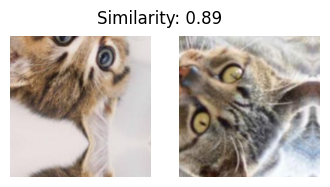

1/1 [==============================] - 0s 21ms/step


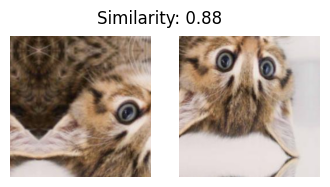

1/1 [==============================] - 0s 21ms/step


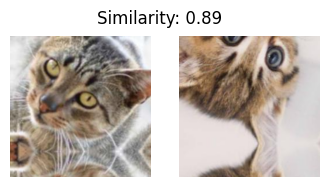

1/1 [==============================] - 0s 23ms/step


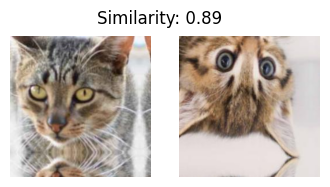

1/1 [==============================] - 0s 21ms/step


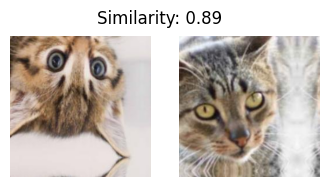

1/1 [==============================] - 0s 20ms/step


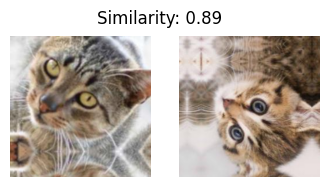

1/1 [==============================] - 0s 21ms/step


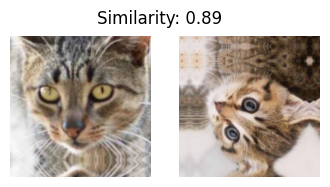

1/1 [==============================] - 0s 20ms/step


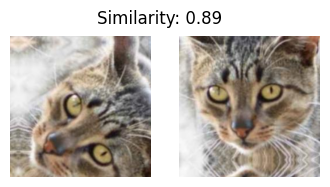

1/1 [==============================] - 0s 21ms/step


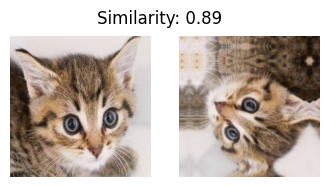

1/1 [==============================] - 0s 21ms/step


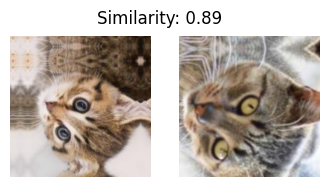

In [32]:
# loop over all image pairs
for (i, (pathA, pathB)) in enumerate(pairs):
	# load both the images and convert them to grayscale
	imageA = plt.imread(pathA)
	imageB = plt.imread(pathB)
	# create a copy of both the images for visualization purpose
	origA = imageA.copy()
	origB = imageB.copy()
	# add a batch dimension to both images
	imageA = np.expand_dims(imageA, axis=0)
	imageB = np.expand_dims(imageB, axis=0)
	# scale the pixel values to the range of [0, 1]
	imageA = imageA / 255.0
	imageB = imageB / 255.0
	# use our siamese model to make predictions on the image pair,
	# indicating whether or not the images belong to the same class
	preds = model.predict([imageA, imageB])
	proba = preds[0][0]
  # initialize the figure
	fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
	plt.suptitle("Similarity: {:.2f}".format(proba))
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(origA, cmap=plt.cm.gray)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(origB, cmap=plt.cm.gray)
	plt.axis("off")
	# show the plot
	plt.show()